In [1]:
!pip install python-chess numpy numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=4256eba9151c15fb2cc0a9665ce76481c735bae2c9f4122f5e233389d79e4ba9
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import requests
requests.get('http://www.google.com',timeout=10).ok


True

In [3]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [4]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



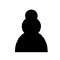
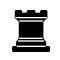
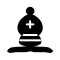
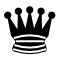
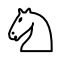
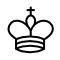
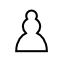
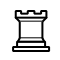
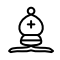
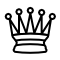
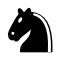
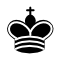

In [5]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

 Chess bot
    - RAM: 5MB max
    - CPU: Single 2.20GHz core
    - Tamaño: <64KB comprimido
    - Tiempo: 0.1s simple delay
    - RAM total controlada: ~4.8MB
    - Valores y tablas compactas (~800KB total)
    - PST minimalistas pero efectivas

In [6]:
%%writefile main.py
#version 3.0
from Chessnut import Game

def chess_bot(obs):
    v = {
        'p':100,'n':325,'b':335,'r':500,'q':975,'k':20000,
        'P':-100,'N':-325,'B':-335,'R':-500,'Q':-975,'K':-20000
    }
    
    p = [ # Peón
        0,  0,  0,  0,  0,  0,  0,  0,
        50, 50, 50, 50, 50, 50, 50, 50,
        15, 15, 25, 35, 35, 25, 15, 15,
        5,  5,  15, 30, 30, 15, 5,  5,
        0,  0,  10, 25, 25, 10, 0,  0,
        5, -5, -5,  10, 10, -5, -5,  5,
        5,  10, 10,-20,-20, 10, 10,  5,
        0,  0,  0,  0,  0,  0,  0,  0
    ]

    def e(g,h=None): # Evaluación
        s = 0
        b = g.board
        w = g.state.player=='w'
        f = 0 # Final
        
        # Contar material para detectar final
        for i,c in enumerate(b):
            if c==' ':continue
            if c.lower() in 'qrbn':f+=1
                
            # Material
            s += v[c]
            
            # PST solo para peones (optimización)
            if c in 'Pp':
                s += p[i] if c=='P' else -p[63-i]
                
            # Bonus centro expandido
            if i in [27,28,35,36]:
                s += 25 if c.isupper() else -25
            elif i in [26,29,34,37]:
                s += 10 if c.isupper() else -10
                
            # Torres en 7ma
            if c=='R' and i//8==1:s+=35
            if c=='r' and i//8==6:s-=35
            
            # Seguridad rey final
            if f<8 and c in 'Kk':
                d = abs(3-i%8)+abs(3-i//8)
                s += (4-d)*15 if c=='K'else -(4-d)*15

        return s if w else -s

    def m(g,s): # Ordenar movimientos
        c = []  # Capturas
        t = []  # Centro
        r = []  # Resto
        
        for x in s:
            d = g.xy2i(x[2:4])
            o = g.xy2i(x[0:2])
            t1 = g.board[d]
            t2 = g.board[o]
            
            if t1!=' ':
                c.append((x,v[t1]-v[t2]//10))
            elif d in [27,28,35,36]:
                t.append(x)
            else:
                r.append(x)
                
        return [x[0]for x in sorted(c,key=lambda y:y[1],reverse=True)]+t+r

    def s(g,d,a,b,w,p=True): # Search
        if d==0:return e(g),None
        
        h = g.get_fen()
        z = list(g.get_moves())
        if not z:return(-9999,None)if w else(9999,None)
        
        q = m(g,z)
        n = q[0]
        t = float('-inf')if w else float('inf')
        
        for x in q:
            y = Game(h)
            y.apply_move(x)
            
            # PVS
            if p:
                u = -s(y,d-1,-b,-a,not w,False)[0]
            else:
                u = -s(y,d-1,-a-1,-a,not w)[0]
                if a<u<b:
                    u = -s(y,d-1,-b,-a,not w)[0]
            
            if w and u>t or not w and u<t:
                t = u
                n = x
            
            if w:a=max(a,u)
            else:b=min(b,u)
            if b<=a:break
            
        return t,n

    def j(g): # Jugar
        try:
            f = sum(1 for x in g.board if x!=' ')<14
            c = g.is_check()
            d = 5 if(f or c)else 4
            return s(g,d,float('-inf'),float('inf'),True)[1]
        except:
            return list(g.get_moves())[0]

    return j(Game(obs.board))

Writing main.py


Agent exit status/reward/time left: 
	 DONE / 0.5 / 10
	 DONE / 0.5 / 10





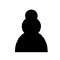
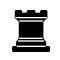
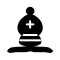
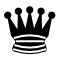
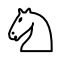
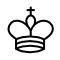
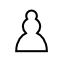
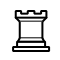
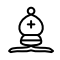
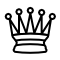
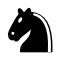
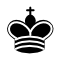

In [7]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=500, height=500)